In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd

import modelling

# 3D plot in parameter space
# Plot for known drugs
param_lib = modelling.BindingParameters()
drug_list = param_lib.drug_compounds

SA_model = modelling.SensitivityAnalysis()
param_names = SA_model.param_names

starting_param_df = pd.DataFrame([1] * 5, index=param_names).T
ComparisonController = modelling.ModelComparison(starting_param_df)

In [13]:
# Read data for space
saved_data_dir = '../../../simulation_results/'
file_prefix = 'SA_APD'
result_files = [saved_data_dir + f for f in os.listdir(saved_data_dir) if f.startswith(file_prefix)]

first_iter = True
for file in result_files:
    df = pd.read_csv(file,
                     header=[0, 1], index_col=[0],
                     skipinitialspace=True)   
    if first_iter:
        combined_df = df
        first_iter = False
    else:
        combined_df = pd.concat([combined_df, df])

APD_trap_avg = []
APD_conduct_avg = []
for r in range(len(combined_df.index)):
    APD_trapping = combined_df.iloc[[r]]['APD_trapping'].values[0]
    nan_ind = [i for i in range(len(APD_trapping)) if np.isnan(APD_trapping[i])]
    APD_trapping = [APD_trapping[i] for i in range(len(APD_trapping)) if i not in nan_ind]
    APD_trapping = [i for i in APD_trapping if i != 1000]
    if not APD_trapping:
        APD_trap_avg.append(float('nan'))
    else:
        APD_trap_avg.append(np.mean(APD_trapping))
    
    APD_conductance = combined_df.iloc[[r]]['APD_conductance'].values[0]
    nan_ind = [i for i in range(len(APD_conductance)) if np.isnan(APD_conductance[i])]
    APD_conductance = [APD_conductance[i] for i in range(len(APD_conductance)) if i not in nan_ind]
    APD_conductance = [i for i in APD_conductance if i != 1000]
    if not APD_conductance:
        APD_conduct_avg.append(float('nan'))
    else:
        APD_conduct_avg.append(np.mean(APD_conductance))
        
Vhalf_range = combined_df['param_values']['Vhalf'].values
Kmax_range = combined_df['param_values']['Kmax'].values
Ku_range = combined_df['param_values']['Ku'].values

cmin = min(min(APD_trap_avg), min(APD_conduct_avg))
cmax = max(max(APD_trap_avg), max(APD_conduct_avg))

In [3]:
# Vhalf_range = combined_df['param_values']['Vhalf'].values
# Kmax_range = combined_df['param_values']['Kmax'].values
# Ku_range = combined_df['param_values']['Ku'].values

# Error_space = RMSError * MError / np.abs(MError)

# Vhalf_range = [Vhalf_range[i] for i in range(len(Vhalf_range)) if i not in nan_ind]
# Kmax_range = [Kmax_range[i] for i in range(len(Kmax_range)) if i not in nan_ind]
# Ku_range = [Ku_range[i] for i in range(len(Ku_range)) if i not in nan_ind]
# Error_space = [Error_space[i] for i in range(len(Error_space)) if i not in nan_ind]

In [4]:
# Vhalf_chosen = combined_chosen_df['param_values']['Vhalf'].values
# Kmax_chosen = combined_chosen_df['param_values']['Kmax'].values
# Ku_chosen = combined_chosen_df['param_values']['Ku'].values

In [5]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

<IPython.core.display.Javascript object>


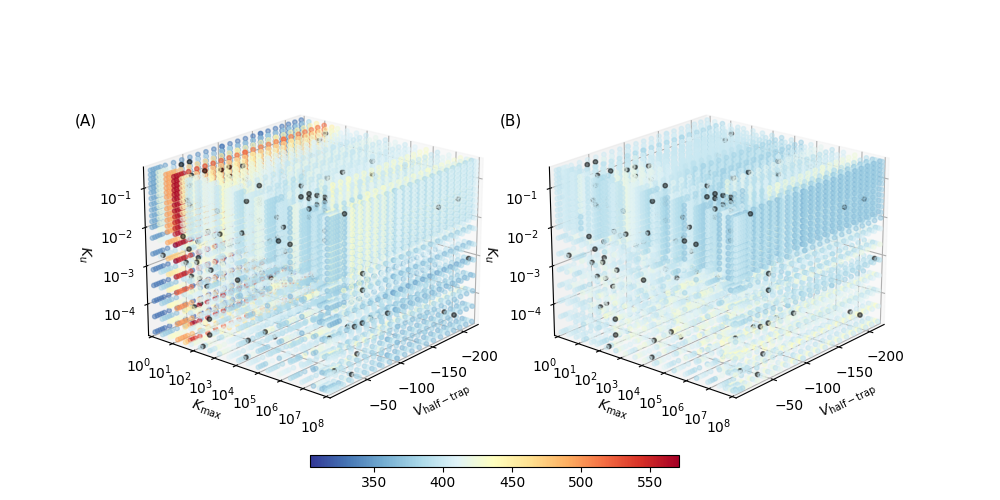

In [18]:
fig = plt.figure(figsize=(10, 5))

gs = fig.add_gridspec(1, 2, wspace=0.1)
axs = [fig.add_subplot(gs[0, j], projection='3d') for j in range(2)]

cmap = plt.get_cmap('RdYlBu_r')
cmap_norm = matplotlib.colors.Normalize(cmin, cmax)
scale_map = matplotlib.cm.ScalarMappable(norm=cmap_norm, cmap=cmap)
# cmap_norm_trap = matplotlib.colors.Normalize(min(APD_trap_avg), max(APD_trap_avg))
# scale_map_trap = matplotlib.cm.ScalarMappable(norm=cmap_norm_trap, cmap=cmap)
# cmap_norm_conduct = matplotlib.colors.Normalize(min(APD_conduct_avg), max(APD_conduct_avg))
# scale_map_conduct = matplotlib.cm.ScalarMappable(norm=cmap_norm_conduct, cmap=cmap)

axs[0].scatter(Vhalf_range, np.log10(Kmax_range), np.log10(Ku_range),
           c=scale_map.to_rgba(APD_trap_avg),
           s=10, marker='o', zorder=-10, alpha=0.5)
axs[0].view_init(20, 40)

axs[1].scatter(Vhalf_range, np.log10(Kmax_range), np.log10(Ku_range),
           c=scale_map.to_rgba(APD_conduct_avg),
           s=10, marker='o', zorder=-10, alpha=0.5)
axs[1].view_init(20, 40)

for i in range(2):
    axs[i].set_xlabel(r"$V_\mathrm{half-trap}$")
    axs[i].set_ylabel(r"$K_\mathrm{max}$")
    axs[i].set_zlabel(r"$K_u$")

    axs[i].set_xlim(min(Vhalf_range), max(Vhalf_range))
    axs[i].set_ylim(min(np.log10(Kmax_range)), max(np.log10(Kmax_range)))
    axs[i].set_zlim(min(np.log10(Ku_range)), max(np.log10(Ku_range)))
    
    axs[i].yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    axs[i].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    axs[i].zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    axs[i].zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    axs[i].set_rasterization_zorder(0)

cax = axs[0].inset_axes([0.5, -0.08, 1, 0.03])
scale_map.set_array(APD_conduct_avg)
fig.colorbar(scale_map, orientation='horizontal', ax=axs, cax=cax, ) 

# cax = axs[0].inset_axes([0.05, -0.08, 1, 0.03])
# scale_map_trap.set_array(APD_trap_avg)
# fig.colorbar(scale_map_trap, orientation='horizontal', ax=axs, cax=cax, ) # , shrink=0.5, )

# cax = axs[1].inset_axes([0.05, -0.08, 1, 0.03])
# scale_map_conduct.set_array(APD_conduct_avg)
# fig.colorbar(scale_map_conduct, orientation='horizontal', ax=axs, cax=cax, ) # , shrink=0.5, )

fig.text(0.075, 0.75, '(A)', fontsize=11)
fig.text(0.5, 0.75, '(B)', fontsize=11)

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(hspace=0)

# saved_fig_dir = '../../../figures/testing/'
# plt.savefig(saved_fig_dir + 'test.png', bbox_inches='tight')
plt.show()